## Description

This notebook contains general exploratory data analysis on the hate speech dataset. The data can be found here:  
https://github.com/Vicomtech/hate-speech-dataset.git  

The process used to collect, annotate, and model (classification) this dataset can be found in the following paper:  
https://arxiv.org/pdf/1809.04444.pdf

In [2]:
import pkg_resources
import subprocess
import sys
import os

REQUIRED = {
  'spacy', 'scikit-learn', 'numpy', 'pandas', 'torch', 
  'pyfunctional', 'textblob', 'seaborn', 'matplotlib'
}

installed = {pkg.key for pkg in pkg_resources.working_set}
missing = REQUIRED - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

import numpy as np
import pandas as pd
from numpy import log, mean
from pandas import Series, DataFrame

from typing import List, Tuple, Union
import glob

from functional import seq
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt

import spacy

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from IPython.display import clear_output

### Read/Load dataset

Notice the train/test splits are already given from the original experimentation (https://arxiv.org/pdf/1809.04444.pdf). 

In [3]:
# dataset git repo
if not os.path.exists("hate-speech-dataset"):
  !git clone https://github.com/Vicomtech/hate-speech-dataset.git
    
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /home/antony/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /home/antony/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/antony/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/antony/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /home/antony/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /home/antony/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [4]:
def readData(paths: List[str], group: str):
  
  pairs = []
  for p in paths:
    
    with open(p) as f:
      file_id = p.split('/')[-1].split('.')[0]
      pairs.append((file_id, f.read(), group))
  
  return pd.DataFrame(pairs, columns=["file_id", "text", "gSet"])

In [4]:
idLabels = pd.read_csv('hate-speech-dataset/annotations_metadata.csv')[["file_id", "label"]]

In [5]:
trainDf = readData(glob.glob('./hate-speech-dataset/sampled_train/*.txt'), 'train')
testDf = readData(glob.glob('./hate-speech-dataset/sampled_test/*.txt'), 'test')

trainDf = trainDf.join(idLabels.set_index('file_id'), on='file_id')
testDf = testDf.join(idLabels.set_index('file_id'), on='file_id')

combDf = trainDf.append(testDf).reset_index(drop=True)

# print label distributions
print("Train dataset:")
print(trainDf['label'].value_counts(), "\n")
print("Test dataset:")
print(testDf['label'].value_counts(), "\n")

print("Total datase shape:")
print(combDf.shape)
combDf.head()

Train dataset:
hate      957
noHate    957
Name: label, dtype: int64 

Test dataset:
noHate    239
hate      239
Name: label, dtype: int64 

Total datase shape:
(2392, 4)


,file_id,text,gSet,label
0,14103132_1,Five is about what I 've found also .,train,noHate
1,14663016_2,Mexicans have plenty of open space in their co...,train,hate
2,13860974_1,I didnt know that bar was owned by a negro i w...,train,hate
3,30484029_2,If I had one it would 've probably made the li...,train,noHate
4,13864997_3,Most White Western Women have the racial sense...,train,hate


# EDA

### 1)

I will extract:
  - sentence length
  - word count
  - sentiment (polarity)
  - subjectivity
  
I am using Textblob for the last 2 metrics. I am not interested in how accurate the model (Textblob model) is to detect sentiment; I just want to quickly see if there is any discriminatory power in either polarity/subjectivity by label. I could use these as an additional feature for my classifier. 

In [6]:
strSer = combDf['text'].str
txtBlob = combDf['text'].apply(lambda s: TextBlob(s))

combDf['sentence_len'] = strSer.len()
combDf['word_count'] = strSer.split().apply(lambda ls: len(ls))
combDf['polarity'] = txtBlob.apply(lambda blob: blob.sentiment.polarity)
combDf['subjectivity'] = txtBlob.apply(lambda blob: blob.sentiment.subjectivity)

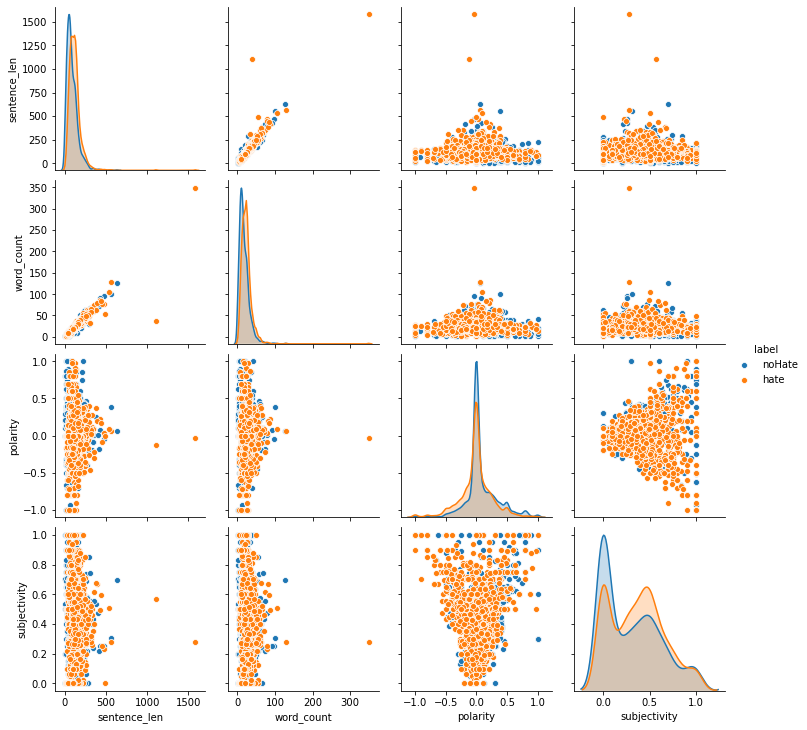

In [7]:
sns.pairplot(
  combDf[['sentence_len', 'word_count', 'polarity', 'subjectivity', 'label']], 
  hue="label"
)

We can see the distributions per category align well on top of each other. There is no discriminatory power in any of these metrics.

### 2) 

In order to get some dataset insight (hate vs noHate) I will do the Log-likelihood test to extract the top words by category. 

In [41]:
!python -m spacy download en_core_web_md & >/dev/null
nlp = spacy.load("en_core_web_sm")

In [9]:
def log_LhArr(src_arr: Series, ref_arr: Series):
  """
  Vectorized log-likelihood test.
  
  Parameters:
  -----------
  - src_arr: sum of tokens across all documents in the source group. Shape (1, n)
  - ref_arr: sum of tokens across all documents in the reference group. Shape (1, n)
  
  Order in which parameters are passed does not affect the results.
  """
  src_count: int = src_arr.sum()
  ref_count: int = ref_arr.sum()
  
  agg = (src_arr + ref_arr) / (src_count + ref_count)
  e1 = src_count * agg
  e2 = ref_count * agg
  
  p1 = src_arr * log(src_arr / e1)
  p2 = ref_arr * log(ref_arr / e2)

  return 2 * (p1 + p2)
  
  
def topWordsByLogLikelihood(
  docWordMatrix: DataFrame, 
  labels: List[str], 
  topN: int) -> Tuple[Series, Series]:
  """
  Prints top words sorted by log likelihood test. 
  Assumes matrix is binary (only 2 labels).
  """
  label1, label2 = set(labels)
  
  aggDf = docWordMatrix.assign(label=labels).groupby('label').sum().T
  
  aggDf = aggDf.assign(
    # difference between token counts in both categories.
    # needed to separate key tokens in each category. 
    l1Diff = aggDf[label1] - aggDf[label2], 
    l2Diff = aggDf[label2] - aggDf[label1],
    # likelihood of all tokens
    # is the likelihood of observing 'this' token in group A significantly different from B
    llikelihood = log_LhArr(aggDf[label1].replace(0, 0.01), aggDf[label2].replace(0, 0.01))
  )
  
  # boolean masks to select tokens in each category
  label1_i = aggDf['l1Diff'] > 0
  label2_i = aggDf['l1Diff'] < 0
  
  l1 = aggDf[label1_i].sort_values(by='llikelihood', ascending=False)[:topN]['llikelihood']
  l2 = aggDf[label2_i].sort_values(by='llikelihood', ascending=False)[:topN]['llikelihood']
  
  print(f"\nTop {label1.upper()} tokens by likelihood:\n")
  print(l1)

  print(f"\nTop {label2.upper()} tokens by likelihood:\n")
  print(l2)
  
  return (l1, l2)

In [10]:
def hateTokenizer(text: str, spacyModel=nlp):
  """
  Simple tokenizer to:
    - extract alphabetical tokens
    - remove stopwords
    - lemmatize and lowercase tokens 
  """
  doc = spacyModel(text)
  
  return seq(token for token in doc)\
    .filter(lambda t: t.is_alpha)\
    .filter_not(lambda t: t.is_stop)\
    .map(lambda t: t.lemma_.lower())\
    .to_list()

In [11]:
def rawCorpusToDf(
  corpus: Union[List[str], Series], 
  tokenizer=hateTokenizer, 
  idf=False) -> DataFrame:
  """Tokenize corpus and build doc-term matrix."""
  vectorizer = (
    TfidfVectorizer(tokenizer=tokenizer, lowercase=False) 
    if idf else
    CountVectorizer(tokenizer=tokenizer, lowercase=False)
  )

  X = vectorizer.fit_transform(corpus)

  return pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())

In [12]:
count_df = rawCorpusToDf(combDf['text'])

In [40]:
l1, l2 = topWordsByLogLikelihood(count_df, combDf['label'].tolist(), 10)


Top NOHATE tokens by likelihood:

youtube    34.454384
post       19.947091
meet       18.984948
pm         17.522085
sf         15.557016
music      13.539330
year       12.337670
march      12.072650
link       11.618006
video      11.291524
Name: llikelihood, dtype: float64

Top HATE tokens by likelihood:

black      58.513906
jews       54.982564
negro      40.754824
ape        33.393051
race       24.915494
scum       24.367472
mud        21.494708
non        20.424957
liberal    20.303212
groid      19.331886
Name: llikelihood, dtype: float64


We can see a qualitative distinction between the 2 groups. The 'hate' words align to what is expected. 

### 3) 

I will do topic modeling with LDA and NMA. I will also get the nouns from all the ***hate*** corpus to have a deeper understanding of all the targets mentioned.

In [14]:
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import silhouette_score

In [15]:
models = list()

for n in range(2, 9):
  lda = LatentDirichletAllocation(n_components=n, random_state=0)
  lda.fit(count_df)
  models.append((n, lda))

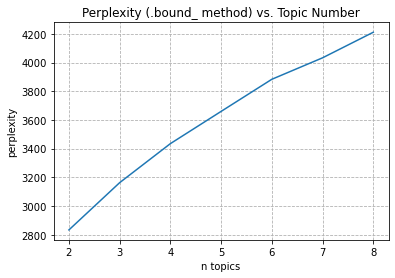

In [16]:
x = [m[0] for m in models]
y = [m[1].bound_ for m in models]

plt.plot(x, y)
plt.xlabel("n topics")
plt.ylabel("perplexity")
plt.title("Perplexity (.bound_ method) vs. Topic Number")
plt.grid(ls='--')
print()

As expected, the more topics the higher the perplexity. Let's use a second metric: silhouette score. This score measures ***group cohesion***, or how closed together data points (documents) are together in relation to their distances to other topics; the higher the score the better. To accomplish this I will assign 1 topic to each document depending on its highest topic probability. Ideas to implement silhouette score on LDA:  
https://www.quora.com/How-is-the-silhouette-coefficient-used-to-find-better-cluster-quality-for-LDA  
http://www.cs.wm.edu/~denys/pubs/talks/ICSE'13.LDA-GA.pdf

In [17]:
silhouette_scores = list()

for m in models:
  # document-topic matrix
  topics = m[1].transform(count_df)
  # index of higher topic probability
  labels = np.argmax(topics, axis=1)
  score = silhouette_score(topics, labels)
  
  silhouette_scores.append((m[0], score))

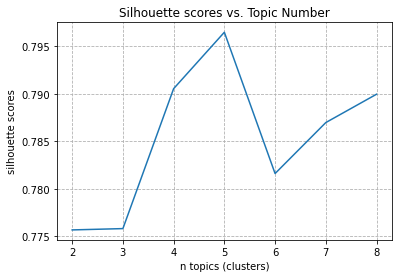

In [18]:
n_topics = [s[0] for s in silhouette_scores]
scores = [s[1] for s in silhouette_scores]

plt.plot(n_topics, scores)
plt.xlabel("n topics (clusters)")
plt.ylabel("silhouette scores")
plt.title("Silhouette scores vs. Topic Number")
plt.grid(ls='--')
print()

We can see that according to group cohesion (silhouette score) the best value would be 5. This value maximizes the ***separability*** of each document mapped to its most relevant topic (topic with highest probability).  

But, like with any topic modeling algorithm, we care more about the interpretability of each topic rather than the optimization of a metric. Let's print the top keywords in each topic. I will choose 2 to 5 topics to see what keywords we find.

In [19]:
def topWords(
  componentsMatrix: Union[DataFrame, np.ndarray],
  words: List[str]=count_df.columns.tolist(),
  topN: int=10) -> None:
  """
  Print top keywords by each component in componentsMatrix.
  
  Parameters:
  -----------
  - componentsMatrix: components matrix from factorization. Shape: (n_topics, tokens_len).
  - words: list with words/tokens. Usually the columns of the document-word matrix.
      Length must be equal to *tokens_len* (see parameter above).
  - topN: number of words to print per topic.
  """
  df = pd.DataFrame(componentsMatrix.T, index=words)
  cols = [f"topic-{t}" for t in df.columns]
  
  finalDf = pd.DataFrame([
    df.sort_values(by=col, ascending=False)[:topN].index
    for col in df.columns
  ]).T
  
  print(finalDf.set_axis(cols, axis=1))

In [20]:
for n, model in models:
  if n > 5:
    break
    
  print("\n", f"Top Keywords With {n} Topics:", "\n")
  topWords(model.components_)


 Top Keywords With 2 Topics: 

  topic-0  topic-1
0   white   people
1   black    black
2    like     like
3    race       go
4    want    white
5  school      get
6  people    think
7     not  country
8    come      new
9    look      day

 Top Keywords With 3 Topics: 

  topic-0  topic-1  topic-2
0   white     like    white
1    like    think    black
2  school   people   people
3    want      new       go
4    race     jews     like
5    time  youtube      non
6     not    white    think
7    look      get     know
8  people  country     come
9   negro      day  country

 Top Keywords With 4 Topics: 

  topic-0  topic-1  topic-2 topic-3
0   white     like    white   white
1    like      new    black     get
2    race   people   people  school
3     not    right     like  people
4    area    black       go    want
5    time  youtube      man      go
6  people    world     year    good
7    want    think  country   negro
8   place      use     come    like
9       m  country    woman

It is hard to distinguish any coherent topic. One reason for LDA poor performance might be that we only have single sentences so a lot of the same words are going to show up everywhere without having a specific topic. If we think of longer texts, we can imagine words having a context around (the same topic in sentences before and after), with single sentences this task might be imposible (this is justn an educated guess).  

Finally, I want to extract all the nouns to search for ***targets*** of hate speech. Perhaps I can't identify topics but I might be able to quickly peek at targets. 

In [21]:
hateText = combDf[combDf['label'] == 'hate']['text'].str.lower()
docs = list(nlp.pipe(hateText, disable=["ner", "textcat"]))

In [35]:
# possible dependency tags
# dobj, nsubj, nsubjpass

nouns = set([token.lemma_ 
  for doc in docs
  for token in doc
  if token.dep_ == 'nsubj' and not token.is_stop and len(token) > 2
])

pairs = [(hateText.str.contains(nn).sum(), nn) for nn in nouns]
targetsDf = pd.DataFrame(pairs, columns=["sentence_count", "target"])

Possible nouns can be found in ***dobj***, ***nsubj***, ***nsubjpass*** (syntactic dependencies). There is no simple way to determine if noun is a person, a thing, or a place, so there needs to be some manual cleaning of the nouns found. I will create a simple funcction to manually delete some of the non-person nouns.

In [71]:
def cleanDfText(df, col_remove='target', col_sort='sentence_count', show=20):
  """
  Utility function to remove words from a column, 1 by 1. Function asks user 
  what word to remove, the new dataframe without the word is printed and the loop repeats.
  
  Parameters:
  -----------
  - df: Pandas Dataframe.
  - col_remove: the column with possible words to remove.
  - col_sort: numerical column to sort by after each loop.
  - show: dataframe number of items to display after each loop.
  """
  newDf = df.copy()
  removed = list()
  
  while True:
    word = input("Word to remove (enter 'q' to exit):")
    
    if word == 'q':
      return removed, newDf
      
    newDf = newDf[newDf[col_remove] != word]\
              .sort_values(by=col_sort, ascending=False)\
              .reset_index(drop=True)
    
    removed.append(word)
    clear_output(wait=True)
    print(newDf.head(show))
    
    # clear Jupyter notebook input/output
    In.clear()
    Out.clear()

In [72]:
# no need to uncomment this. Utility function *cleanDfText* was used 
# to remove 'non-person' nouns. Words removed are typed in next cell. 
# removed, targetsCleanDf = cleanDfText(targetsDf)

In [73]:
toRemove = ['er','lack','one','use','man','ted','people','way','race',
 'red','cause','non','ape','rat','time','son','country','don','thing',
 'school','world','child','hate','work','kid','lie','nation','scum','hell','mud',
 'filth','human','sex','house','being','car','arm','place','crime','guy',
 'crap','breed','news','town','male'
]

targetsDf[~targetsDf['target'].str.contains("|".join(toRemove))]\
  .sort_values(by="sentence_count", ascending=False)\
  .reset_index(drop=True).head(15)

,sentence_count,target
0,295,white
1,127,jew
2,94,negro
3,63,jews
4,47,africa
5,38,nig
6,37,asian
7,33,negroes
8,29,groid
9,27,god


We can see the main target for these comments are blacks and jews with some minor mention of asians and muslims. This is expected given that data was gathered from a *white supremacist* forum. It might be interesting to quantify who are the primary targets of hate speech in different social media platforms. 